# Vlasiator - A Global Hybrid-Vlasov Simulation Model 
Vlasiator [@palmroth2018] is an open-source simulation software used to model the behavior of plasma in the Earth's magnetosphere, a region of space where the solar wind interacts with the Earth’s magnetic field. Vlasiator models collisionless space plasma dynamics by solving the 6-dimensional Vlasov equation, using a hybrid-Vlasov approach. It uses a 3D Cartesian grid in real space, with each cell storing another 3D Cartesian grid in velocity space. The velocity mesh contained in each spatial cell in the simulation domain has been represented so far by a sparse grid approach, fundamentally based on an associative container such as a key-value hashtable. Storing a 3D VDF at every spatial cells increases the memory requirements exponentially both during runtime and for storing purposes. Our proposal revolves around developing innovative solutions to compressing the VDFs during runtmime.

![title](images/egi.png)


# VDF Compression

## Initialization
Let's read in a vdf from a sample file and see what that looks like.

In [1]:
import sys,os
import warnings
warnings.filterwarnings('ignore')
# sys.path.append('/home/mjalho/analysator')
import tools as project_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.colors as colors
# plt.rcParams['figure.figsize'] = [7, 7]
import ctypes
import pyzfp,zlib
import mlp_compress
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import pytools

Using LaTeX formatting
Using backend module://matplotlib_inline.backend_inline
Note: Did not import (outdated MayaVi2) grid module:  No module named 'traits'
Using matplotlib version 3.7.1


Found population proton
Getting offsets for population proton
VDF shape = (50, 50, 50)


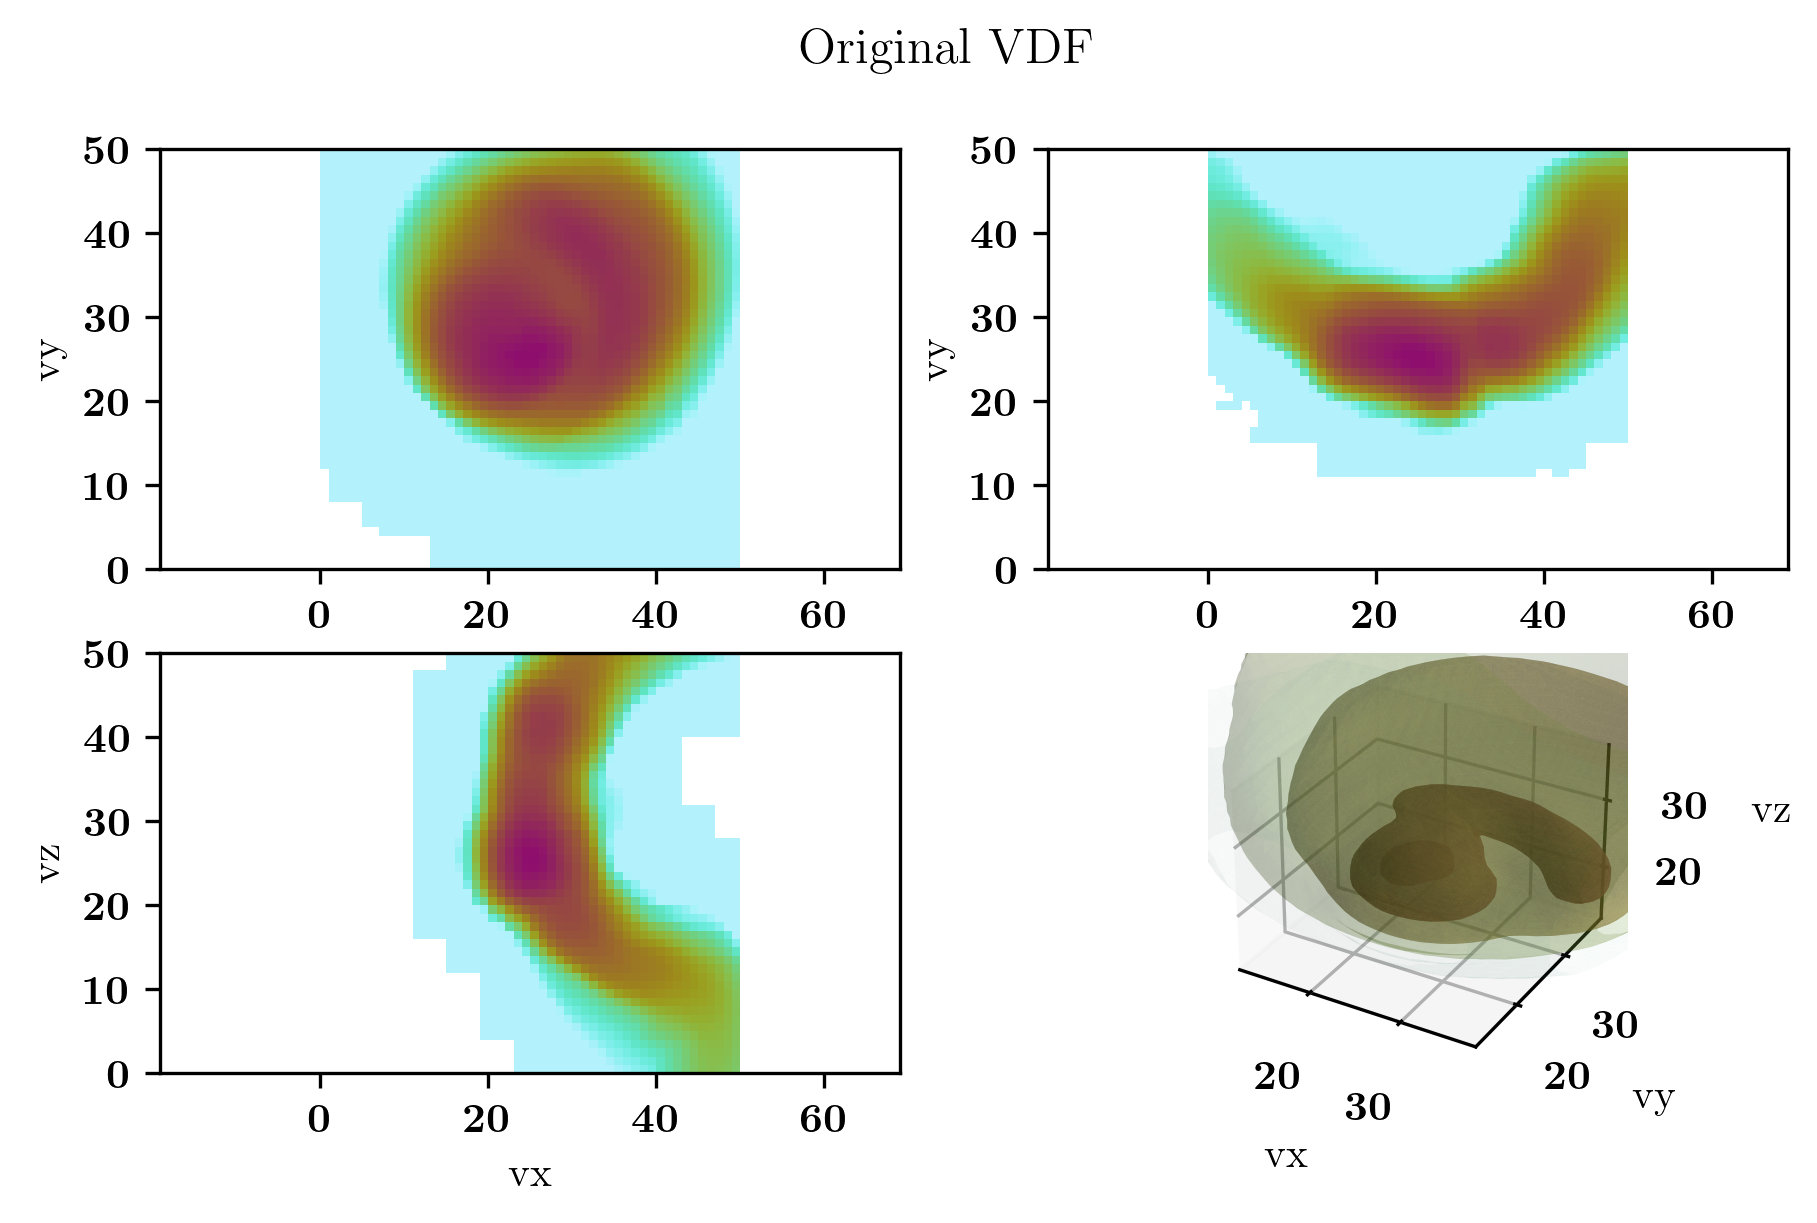

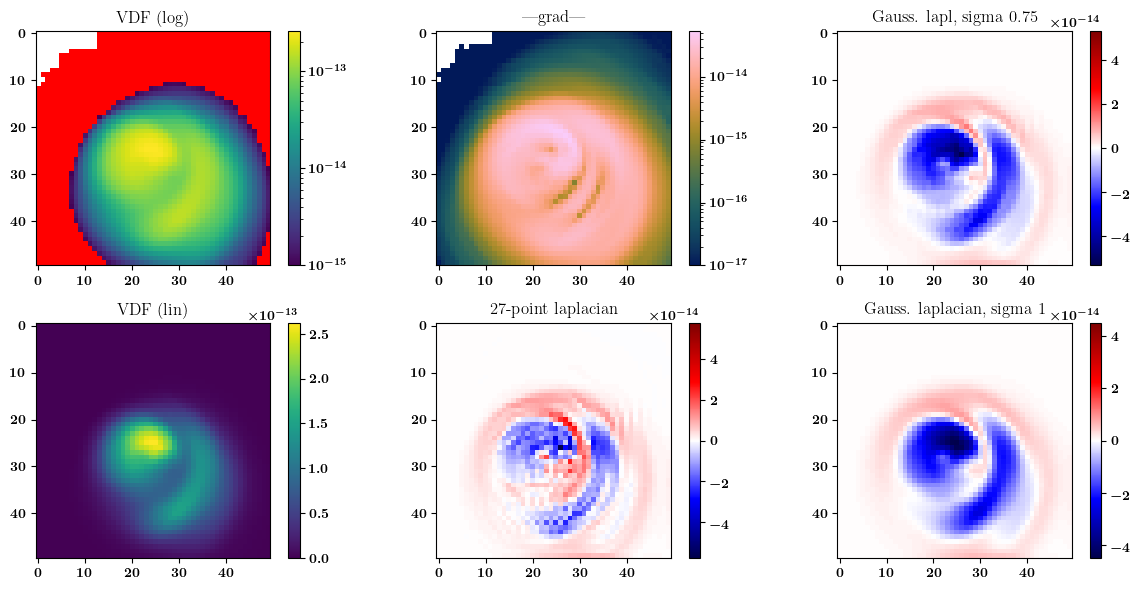

In [2]:
file="assets/bulk1.0001280.vlsv";cid=356780649;
#Read the VDF into a 3D uniform mesh and plot it
vdf=project_tools.extract_vdf(file,cid,25)
# np.save("sample_vdf.bin",np.array(vdf,dtype=np.double));
np.array(vdf,dtype=np.double).tofile("sample_vdf.bin")
nx,ny,nz=np.shape(vdf)
print(f"VDF shape = {np.shape(vdf)}")
fig = plt.figure(figsize=[7,4], dpi=300);
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='3d')
# , ax2, ax3) = plt.subplots(1, 3)


cmap = 'viridis'
cmap = 'hawaii_r'
norm = colors.LogNorm(vmin=1e-15,vmax=3e-13)
im1 = ax1.pcolormesh(vdf[:,:,nz//2],norm=norm,rasterized=False,cmap=cmap)
# im1 = ax1.imshow(vdf[:,:,nz//2],norm=norm,cmap=cmap, origin='lower')
im2 = ax2.pcolormesh(vdf[nx//2,:,:].T,norm=norm,rasterized=False,cmap=cmap)
im3 = ax3.pcolormesh(vdf[:,ny//2,:],norm=norm,rasterized=False,cmap=cmap)
ax1.axis('equal')
ax1.set_xlabel('vx')
ax1.set_ylabel('vy')
ax2.axis('equal')
ax2.set_xlabel('vz')
ax2.set_ylabel('vy')
ax3.axis('equal')
ax3.set_xlabel('vx')
ax3.set_ylabel('vz')

level = 1e-14
for level in [3e-15,1e-14,3e-14,1e-13,2e-13]:
    verts, faces, normals, values = measure.marching_cubes(vdf, level)
    mesh = Poly3DCollection(verts[faces], shade=True, facecolors=mpl.colormaps[cmap](norm(level)), alpha = norm(level)**2)
    ax4.add_collection3d(mesh)

ax4.set_xlim(nx/4,3*nx/4)
ax4.set_ylim(ny/4,3*ny/4)
ax4.set_zlim(nz/4,3*nz/4)
ax4.set_xlabel('vx')
ax4.set_ylabel('vy')
ax4.set_zlabel('vz')

# cax = fig.add_axes([0.7,0.1,0.2,0.05])
# fig.colorbar(im1, cax=cax, location='bottom')
fig.suptitle("Original VDF")
plt.show()

project_tools.plot_vdf_discrete_laplacians(vdf)

The vdf shown above is sampled on a uniform 3D velocity mesh and contains 64bit floating point numbers that represent the phase space density. We can calculate the total size of this VDF is bytes using ```sys.getsizeof(vdf)```.

In [3]:
vdf_mem=sys.getsizeof(vdf)
num_stored_elements=len(vdf[vdf>1e-15])
print(f"VDF takes {vdf_mem} B.")

VDF takes 500144 B.


Now in Vlasiator we have countlesss VDFs since there is one per spatial cell. It would be great if we could compress them efficiently.

## Compression algorithms

### Zlib: lossless floating point compression
We can try to do so by using zlib which is a form of lossless compression. The reconstruction is accurate, by definition, but the compression ratio is small.

Achieved compression ratio using zlib= 1.54.


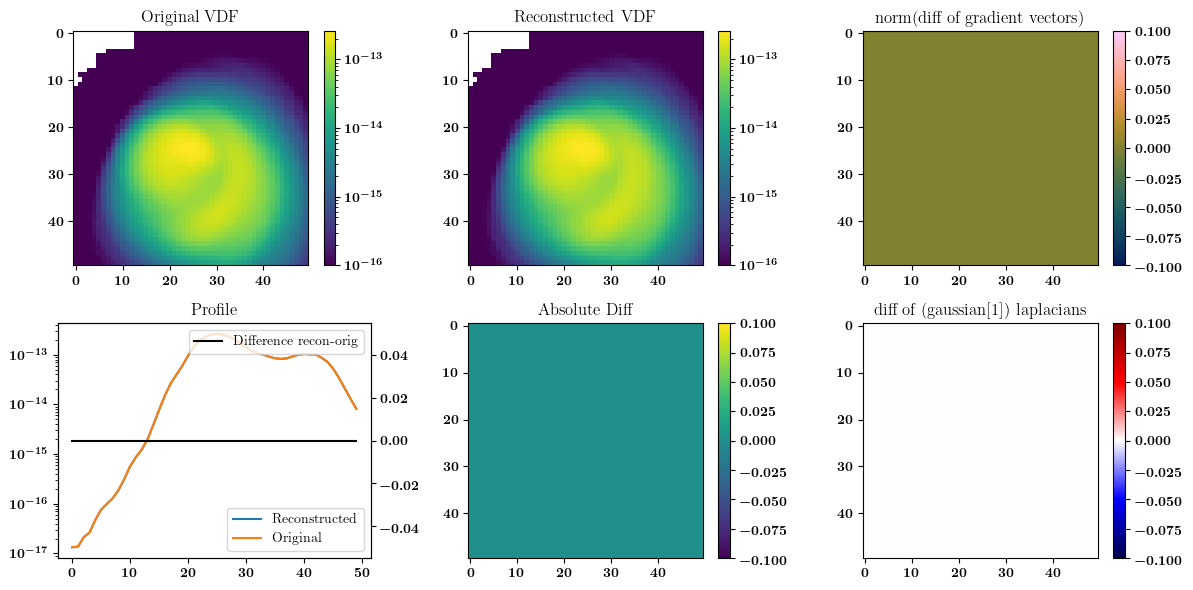

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (0.0, 0.0, '0.e+00', '0.e+00') %.
L1,L2 rNorms= (0.0, 0.0).


In [4]:
compressed_vdf = zlib.compress(vdf)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zlib= {round(compression_ratio,2)}.")
decompressed_vdf = zlib.decompress(compressed_vdf)
recon = np.frombuffer(decompressed_vdf, dtype=vdf.dtype).reshape(vdf.shape)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### zfp: lossy floating point compression
We can use a lossy compression method like zfp[@zfp] to get even higher compression ratios.

Achieved compression ratio using zfp= 87.32.


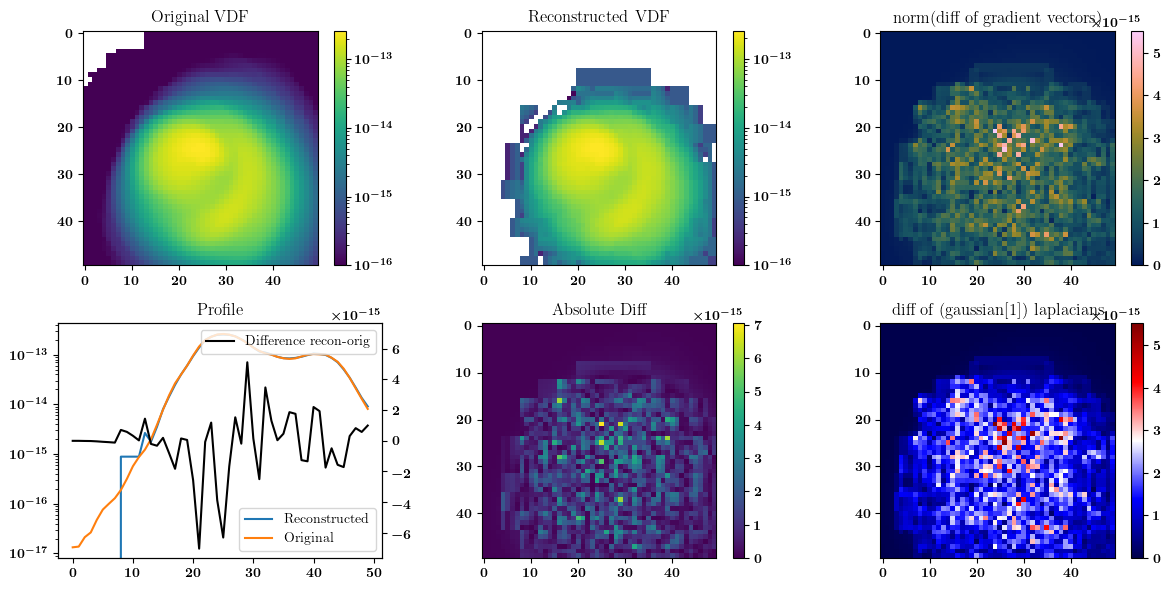

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (0.083, 0.0, '2.506e+00', '2.490e+00') %.
L1,L2 rNorms= (0.046, 0.032).


In [5]:
"""
Compresses a VDF  using ZFP (Zstandard Compressed FP)
Input:VDF - numpy array 
Output: recon (Reconstructed VDF) - numpy array 
"""
tolerance = 1e-13
compressed_vdf = pyzfp.compress(vdf, tolerance=tolerance)
compressed_vdf_mem=len(compressed_vdf)
compression_ratio=vdf_mem/compressed_vdf_mem
print(f"Achieved compression ratio using zfp= {round(compression_ratio,2)}.")
recon = pyzfp.decompress(compressed_vdf,vdf.shape,vdf.dtype,tolerance)
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### Multilevel Perceptron (MLP)

This is based on [@park2019].

Reading VDF from sample_vdf.bin
Cost at epoch 0 is 5.1795
Cost at epoch 1 is 0.4738
Cost at epoch 2 is 0.4627
Cost at epoch 3 is 0.4328
Cost at epoch 4 is 0.4148
Cost at epoch 5 is 0.4057
Cost at epoch 6 is 0.3846
Cost at epoch 7 is 0.3446
Cost at epoch 8 is 0.3333
Cost at epoch 9 is 0.2979
Cost at epoch 10 is 0.2551
Cost at epoch 11 is 0.2183
Cost at epoch 12 is 0.1779
Cost at epoch 13 is 0.1578
Cost at epoch 14 is 0.1445
Cost at epoch 15 is 0.1277
Cost at epoch 16 is 0.1146
Cost at epoch 17 is 0.1019
Cost at epoch 18 is 0.0924
Cost at epoch 19 is 0.0863
Bytes serialized 11456/11456.
Done in 15.49 s.  Compression ratio = 87.66x .


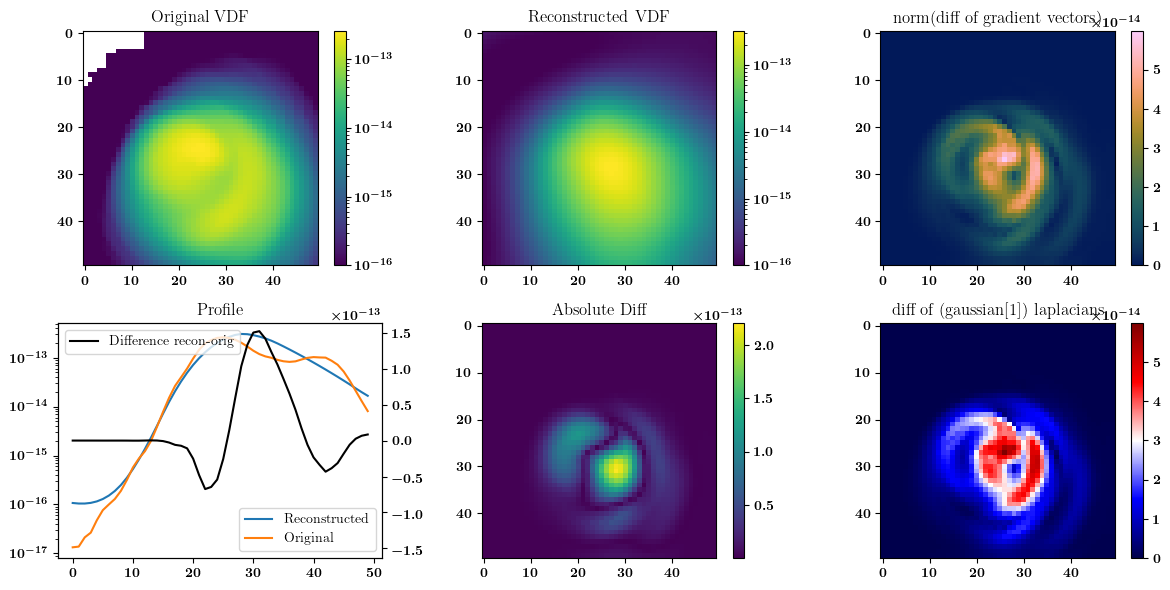

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (7.066, 1.412, '6.630e+01', '4.347e+01') %.
L1,L2 rNorms= (0.383, 0.489).


In [6]:
"""
Compresses a VDF using an MLP (Multilayer Perceptron).
 Input: "sample_vdf.bin" - Binary file containing the VDF data
        order - Order of the fourier features
        epochs - Number of training epochs for the MLP model
        n_layers - Number of layers in the MLP model
        n_neurons - Number of neurons in each layer of the MLP model
 Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""
order=0
epochs=20
n_layers=4
n_neurons=25
nx,ny,nz=np.shape(vdf)
recon=mlp_compress.compress_mlp("sample_vdf.bin",order,epochs,n_layers,n_neurons, nx)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### MLP with Fourier features 

We will compress the VDF using an MLP with Fourier Features, which significantly improves MLP performance [@2020fourier].

Reading VDF from sample_vdf.bin
Cost at epoch 0 is 4.3151
Cost at epoch 1 is 0.0362
Cost at epoch 2 is 0.0240
Cost at epoch 3 is 0.0169
Cost at epoch 4 is 0.0134
Cost at epoch 5 is 0.0116
Cost at epoch 6 is 0.0110
Cost at epoch 7 is 0.0102
Cost at epoch 8 is 0.0095
Cost at epoch 9 is 0.0091
Cost at epoch 10 is 0.0093
Cost at epoch 11 is 0.0091
Cost at epoch 12 is 0.0089
Cost at epoch 13 is 0.0089
Cost at epoch 14 is 0.0088
Cost at epoch 15 is 0.0088
Cost at epoch 16 is 0.0087
Cost at epoch 17 is 0.0086
Cost at epoch 18 is 0.0085
Cost at epoch 19 is 0.0081
Bytes serialized 30656/30656.
Done in 34.96 s.  Compression ratio = 32.67x .


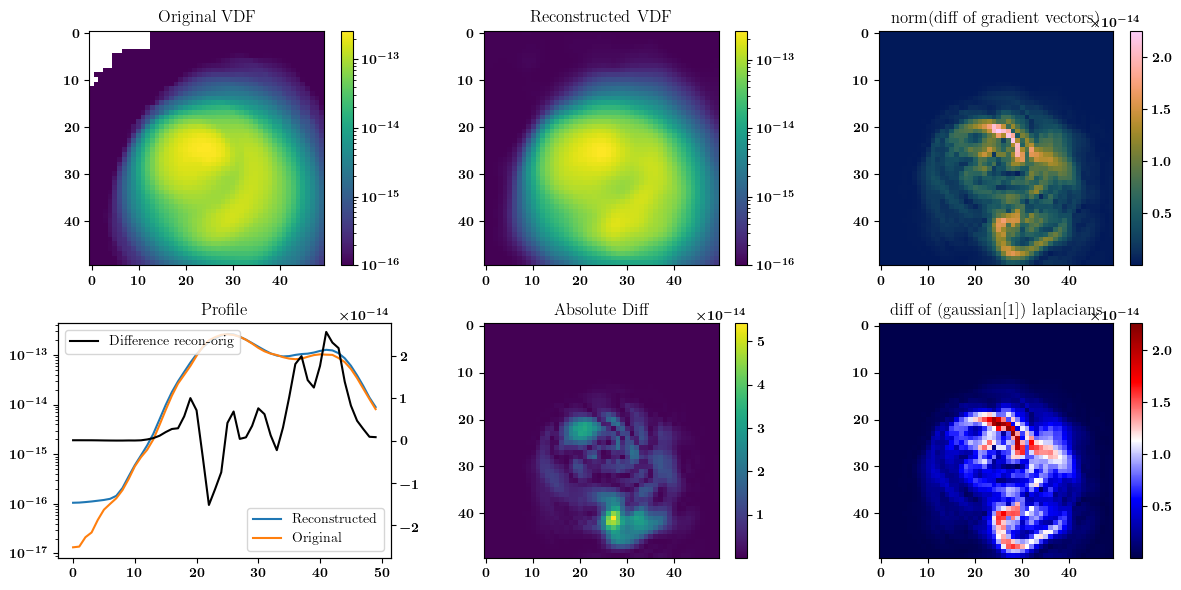

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (5.26, 0.183, '6.372e+00', '8.255e+00') %.
L1,L2 rNorms= (0.108, 0.12).


In [7]:
"""
Compresses a VDF using an MLP (Multilayer Perceptron).
 Input: "sample_vdf.bin" - Binary file containing the VDF data
        order - Order of the fourier features
        epochs - Number of training epochs for the MLP model
        n_layers - Number of layers in the MLP model
        n_neurons - Number of neurons in each layer of the MLP model
 Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""
order=16
epochs=20
n_layers=4
n_neurons=25
nx,ny,nz=np.shape(vdf)
recon=mlp_compress.compress_mlp("sample_vdf.bin",order,epochs,n_layers,n_neurons,nx)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

### Spherical Harmonic Decomposition

Spherical harmonics have been suggested as a usable approximation for VDFs in our subject domain [@vinas_gurgiolo_2009]. Here we investigate if the method can be employed as a compression method. This prototype should be improved by using e.g., the Misner [@misner_2004] method.

Reading VDF from sample_vdf.bin
Compression ratio = 41.322315x .


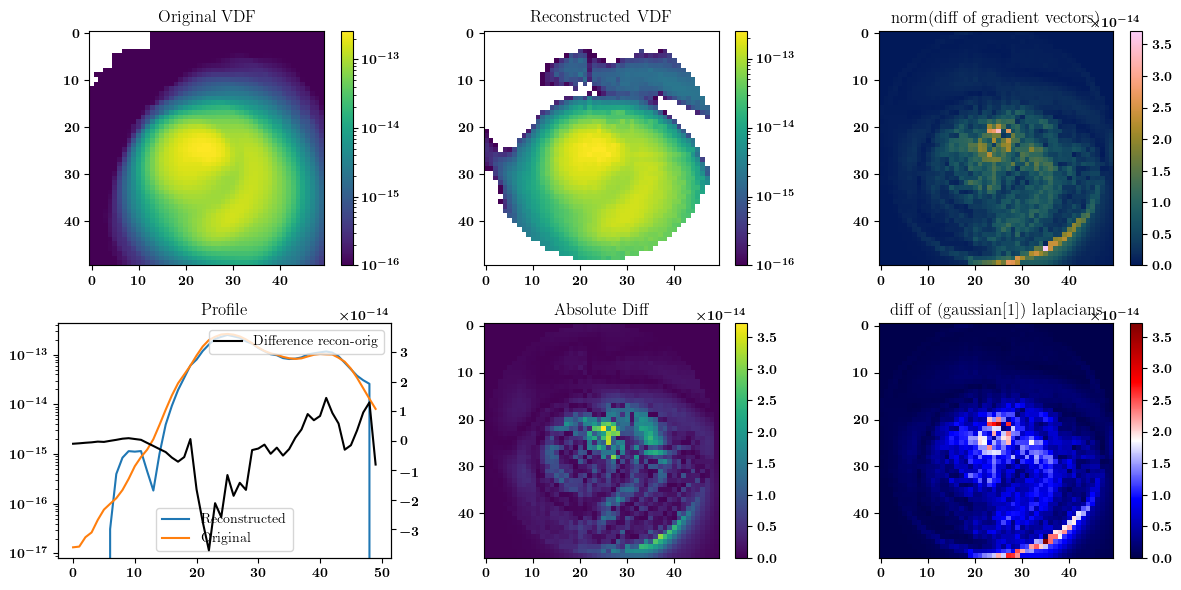

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (25.905, 6.178, '1.180e+02', '8.576e+01') %.
L1,L2 rNorms= (0.368, 0.318).


In [8]:
"""
Compresses a VDF using a spherical harmonic decompostion
Input: "sample_vdf.bin" - Binary file containing the VDF data
       degree - Degree of the spherical harmonic decomposition (l)
Output: recon (Reconstructed VDF) - NumPy array representing the reconstructed volume data
"""

degree=10
nx,ny,nz=np.shape(vdf)
recon=mlp_compress.compress_sph("sample_vdf.bin",degree,nx)
recon=np.array(recon,dtype=np.double)
recon= np.reshape(recon,np.shape(vdf),order='C')
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)


### Convolutional Neural Network (CNN)

Epoch [100/100], Loss: 0.0768
Compresion achieved using a CNN = 3.5


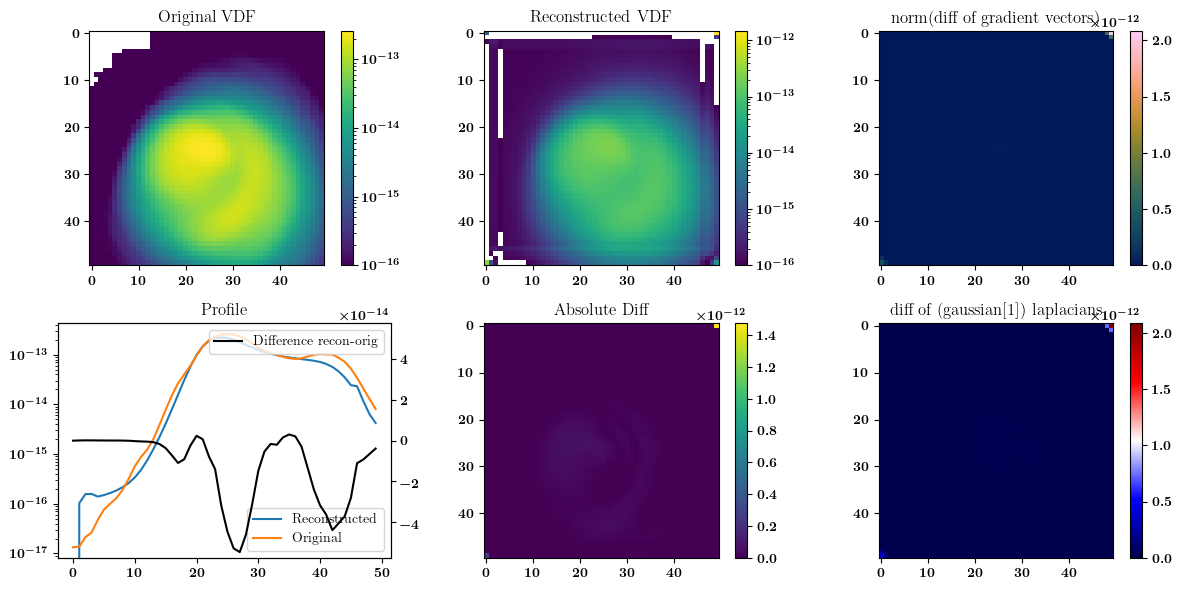

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (196.788, 43.334, '2.e+02', '2.e+02') %.
L1,L2 rNorms= (122.922, 1.0).


In [9]:
"""
Function: train_and_reconstruct

Description:
This function takes an input array and trains a Convolutional Neural Network (CNN) model to reconstruct the input array.
It uses Mean Squared Error (MSE) loss and the Adam optimizer for training.

Inputs:
- input_array (numpy array): The input array to be reconstructed.
- num_epochs (int, optional): The number of training epochs.
- learning_rate (float, optional): The learning rate for the Adam optimize.
Outputs:
    Reconstructed vdf array 
    Size of model in bytes
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

def train_and_reconstruct(input_array, num_epochs=30, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions, move to device
    model = CNN().to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_tensor = model(input_tensor)
        loss = criterion(output_tensor, input_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100== 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    reconstructed_array = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size)   
    return reconstructed_array, size


vdf_temp=vdf.copy()
vdf_temp[vdf_temp<1e-16]=1e-16
vdf_temp = np.log10(vdf_temp)
input_array=vdf_temp
recon,total_size= train_and_reconstruct(input_array,100)
recon = 10 ** recon
recon[recon <= 1e-16] = 0
vdf_size=nx*ny*nz*8
print(f"Compresion achieved using a CNN = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,recon)
project_tools.print_comparison_stats(vdf,recon)

#### CNN with minibatches


Here we still use a CNN but this time we use minibatch training and batch normalization layers to try and improve performance.

Compression achieved using a CNN = 3.48


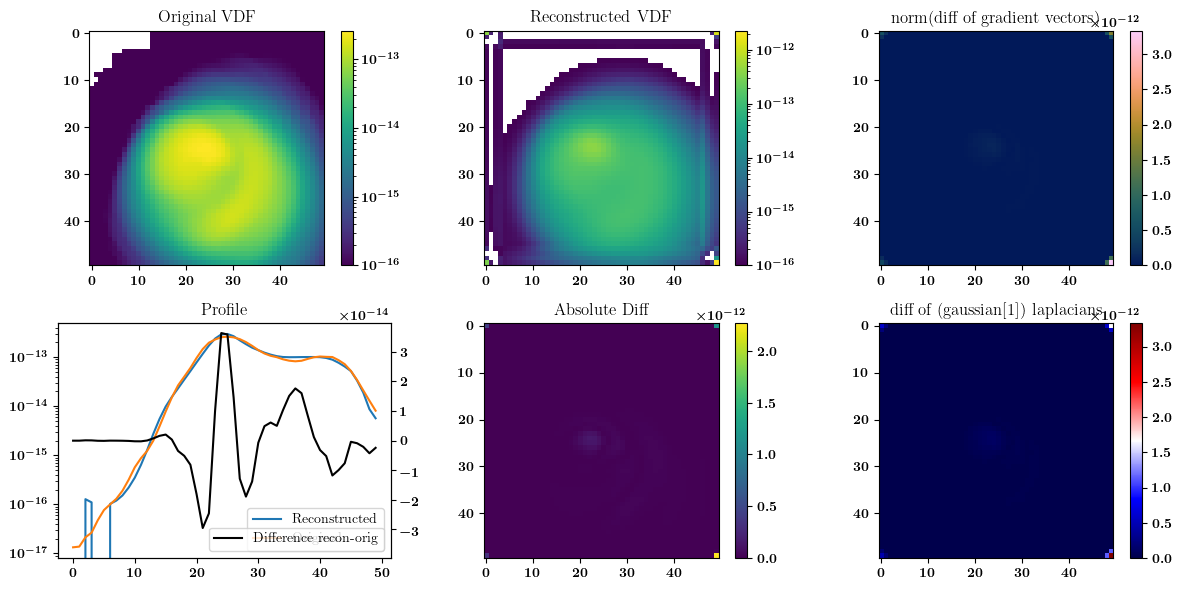

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (199.42, 29.762, '2.e+02', '2.e+02') %.
L1,L2 rNorms= (687.667, 1.0).


In [10]:
"""
Function: train_and_reconstruct

Description:
This function takes an input array and trains a Convolutional Neural Network (CNN) model to reconstruct the input array.
It uses Mean Squared Error (MSE) loss and the Adam optimizer for training.

Inputs:
- input_array (numpy array): The input array to be reconstructed.
- num_epochs (int, optional): The number of training epochs.
- learning_rate (float, optional): The learning rate for the Adam optimizer
Outputs:
    Reconstructed vdf array 
    Size of model in bytes
"""
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        return x

def train_and_reconstruct(input_array, num_epochs=30, learning_rate=0.001, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Move input tensor to device
    model = CNN().to(device) 
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i in range(0, input_tensor.size(0), batch_size):
            optimizer.zero_grad()
            batch_input = input_tensor[i:i+batch_size]
            output_tensor = model(batch_input)
            loss = criterion(output_tensor, batch_input)
            loss.backward()
            optimizer.step()
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    reconstructed_array = output_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size = (param_size + buffer_size)   
    return reconstructed_array, size

vdf_temp = vdf.copy()
vdf_temp[vdf_temp < 1e-16] = 1e-16
vdf_temp = np.log10(vdf_temp)
input_array = vdf_temp
recon, total_size = train_and_reconstruct(input_array, 100)

recon = 10 ** recon
recon[recon <= 1e-16] = 0
vdf_size = nx * ny * nz * 8
print(f"Compression achieved using a CNN = {round(vdf_size / total_size, 2)}")

project_tools.plot_vdfs(vdf, recon)
project_tools.print_comparison_stats(vdf, recon)


### Hermite Decomposition 

loading done
Maxwell fit done
array with base polynomials created
Forward transform done
mode number 0
mode number 1
mode number 2
mode number 3
mode number 4
mode number 5
mode number 6
mode number 7
mode number 8
mode number 9
mode number 10
mode number 11
mode number 12
mode number 13
mode number 14
Inverse transform done
Compresion achieved using Hermite = 36.98


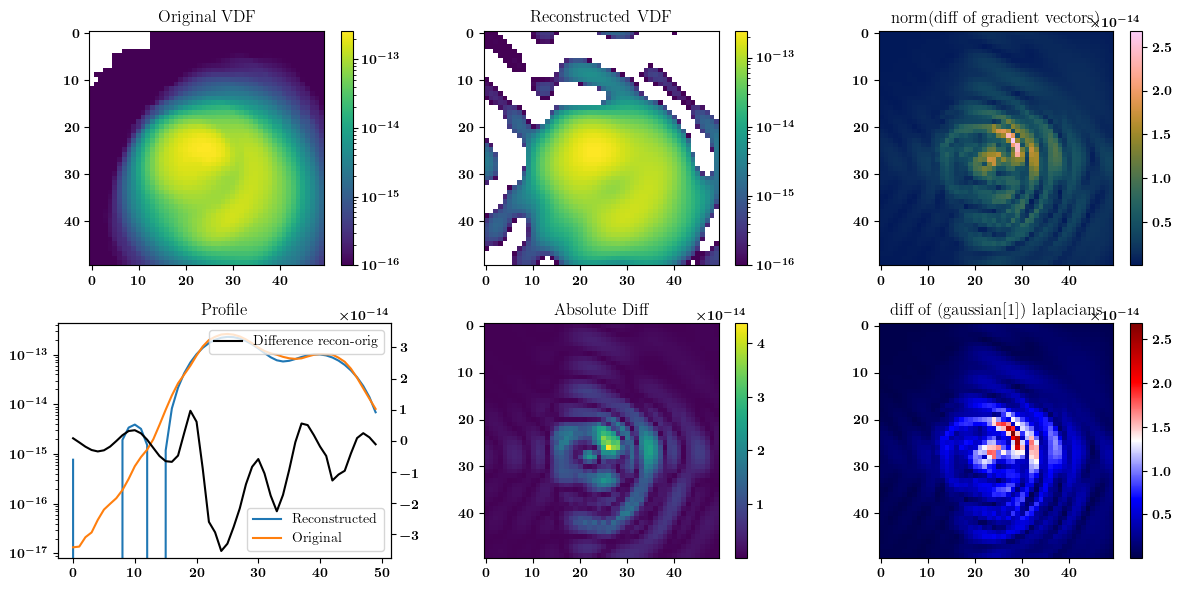

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (10.802, 2.579, '5.591e+01', '3.604e+01') %.
L1,L2 rNorms= (0.175, 0.143).


In [11]:
"""
Loads the original 3D VDF and fits it to a Maxwellian distribution.
  Input: vdf - numpy array representing the original 3D VDF
  Output: vdf_herm_3d Reconstructed VDF using Hermite Decomposition
"""
### load original 3d vdf and fit Maxwellian
vdf_3d=vdf.copy()
print('loading done')
vdf_size=nx*ny*nz*8

#### Fit Maxwellian
v_min,v_max,n_bins=0,nx,nx ### define limits and size of velocity axes

amp,ux,uy,uz,vthx,vthy,vthz=1e-14,nx,nx,nx,10,10,10 ### initial guess for scipy curve fit
guess=amp,ux,uy,uz,vthx,vthy,vthz ### initial guess for scipy curve fit

max_fit_3d,params=project_tools.max_fit(vdf_3d,v_min,v_max,n_bins,guess) ### fitting
print('Maxwell fit done')


#### forward transform ####
mm=15 ### PUT THE NUMBER OF HARMONICS
norm_amp,u,vth=params[0],params[1:4],params[4:7] ### get the maxwellin fit parameters of thermal and bulk velocity

vdf_3d_norm=vdf_3d/norm_amp ### normalize data
vdf_3d_flat= vdf_3d_norm.flatten() ### flatten data

v_xyz=project_tools.get_flat_mesh(v_min,v_max,n_bins) ### flattening the mesh nodes coordinates
herm_array=np.array(project_tools.herm_mpl_arr(m_pol=mm,v_ax=v_xyz,u=params[1:4],vth=params[4:7])) ### create array of hermite polynomials

hermite_matrix=project_tools.coefficient_matrix(vdf_3d_flat,mm,herm_array,v_xyz) ### calculate the coefficients of the Hermite transform
print('Forward transform done')
total_size =5*8+8*np.prod(np.shape(hermite_matrix))

#### inverse transform ####
inv_herm_flat=project_tools.inv_herm_trans(hermite_matrix, herm_array, v_xyz) ### inverse Hermite transform
vdf_herm_3d = (np.reshape(inv_herm_flat,(n_bins,n_bins,n_bins)))*norm_amp ### reshaping back to 3d array and renormalization
print('Inverse transform done')
print(f"Compresion achieved using Hermite = {round(vdf_size/total_size,2)}")
project_tools.plot_vdfs(vdf,vdf_herm_3d)
project_tools.print_comparison_stats(vdf,vdf_herm_3d)

### Gaussian Mixture Model (GMM)

reconstruction: n pop done 0
reconstruction: n pop done 1
reconstruction: n pop done 2
reconstruction: n pop done 3
reconstruction: n pop done 4
reconstruction: n pop done 5
reconstruction: n pop done 6
reconstruction: n pop done 7
reconstruction: n pop done 8
reconstruction: n pop done 9
reconstruction: n pop done 10
reconstruction: n pop done 11
reconstruction: n pop done 12
reconstruction: n pop done 13
reconstruction: n pop done 14
Compresion achieved using GMM = 625.0


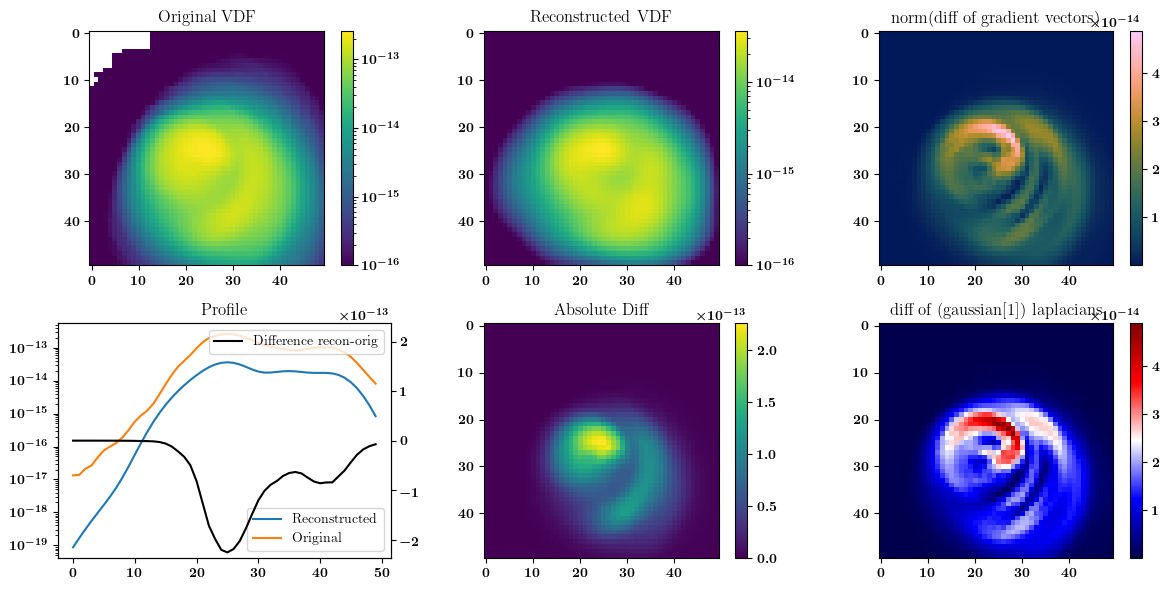

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (125.727, 5.082, '1.228e+02', '1.149e+02') %.
L1,L2 rNorms= (0.773, 4.201).


In [12]:
"""
 Loads the original 3D VDF and performs Gaussian Mixture Model (GMM) decomposition.
 Input: vdf - NumPy array representing the original 3D VDF
 Output: vdf_rec Reconstructed VDF using GMM
"""
#### load original 3d vdf
vdf_3d=vdf.copy()

### define number of populations and normalization parameter
n_pop=15
norm_range=300

### RUN GMM
means,weights,covs,norm_unit=project_tools.run_gmm(vdf_3d,n_pop,norm_range)
### reconstruction resolution and limits of v_space axes
n_bins=nx
v_min,v_max=0,nx

### reconstruction of the vdf 
vdf_rec=project_tools.reconstruct_vdf(n_pop,means,covs,weights,n_bins,v_min,v_max)
vdf_rec=vdf_rec*norm_unit*norm_range
total_size =5*8+8*np.prod(np.shape(np.array(covs)))+8*np.prod(np.shape(np.array(weights)))+8*np.prod(np.shape(np.array(means)))
print(f"Compresion achieved using GMM = {round(vdf_size/total_size,2)}")

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)

### Octree based polynomial approximation

- Modify `maxiter` parameter or `tol` parameter to get different levels of accuracy.
- This is pretty slow since its just a single thread cpu implementation with very conservative refinement policy. 

  Activating project at `~/Desktop/PhD/ASTERIX-IB/asterix-ib/src/jl_env`


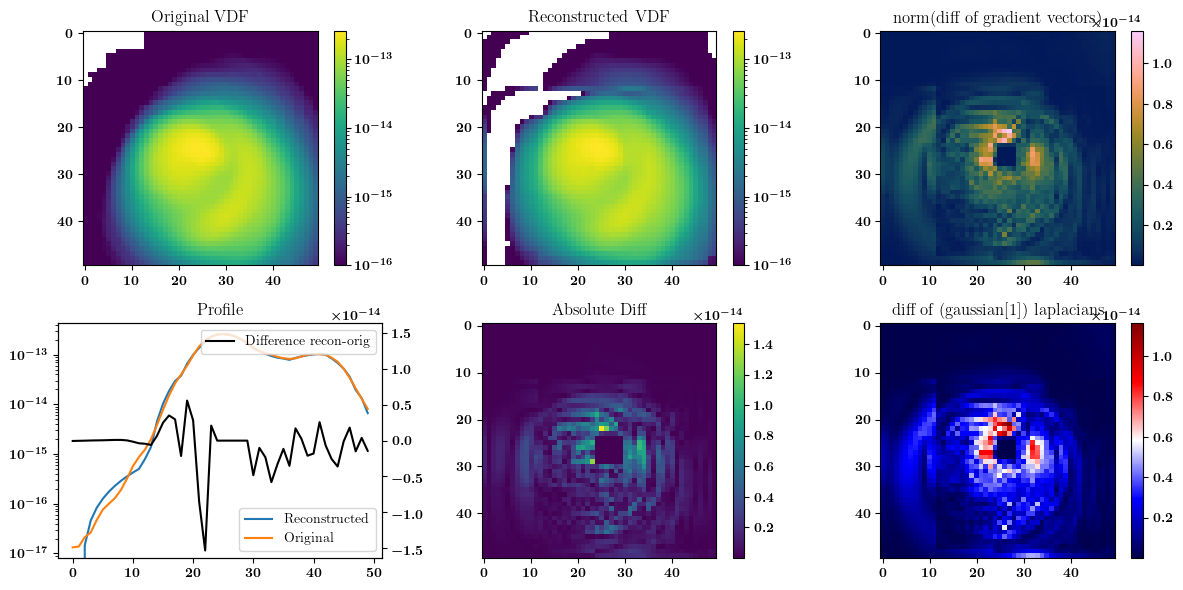

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (1.345, 0.533, '2.55e+01', '1.347e+01') %.
L1,L2 rNorms= (0.068, 0.06).
Number of leaves: 295 * basis size: 27 = 7965
Compression achieved with Octree = 0.024. Assuming 8 octals per leaf for geometry representation.


In [29]:
from juliacall import Main as jl
jl.Pkg.activate("src/jl_env")
jl.Pkg.instantiate()
jl.include("src/octree.jl")
vdf_3d = vdf.copy()
A, b, img, reco, cell, tree = jl.VDFOctreeApprox.compress(vdf_3d, maxiter=500, alpha=0.0, beta=1.0, nu=2, tol=3e-1, verbose=False)
project_tools.plot_vdfs(vdf, reco)
project_tools.print_comparison_stats(vdf,reco)
vdf_size = nx * ny * nz * 8
print(f"Number of leaves: {len(tree)} * basis size: {len(b)} = {len(tree)*len(b)}")
print(f"Compression achieved with Octree = {round((len(b)*len(tree)*3)/vdf_size,3)}. Assuming 8 octals per leaf for geometry representation.")

### Discrete Cosine Transform (DCT)

DCT is simple to implement and is based on linear operations. This is widely used as the JPEG compression standard for images, but it can be extended to 3D distributions as well. Blockyness is apparent, and there is little room for fine-tuning: block size and number of retained DCT components.

compression: 8.0


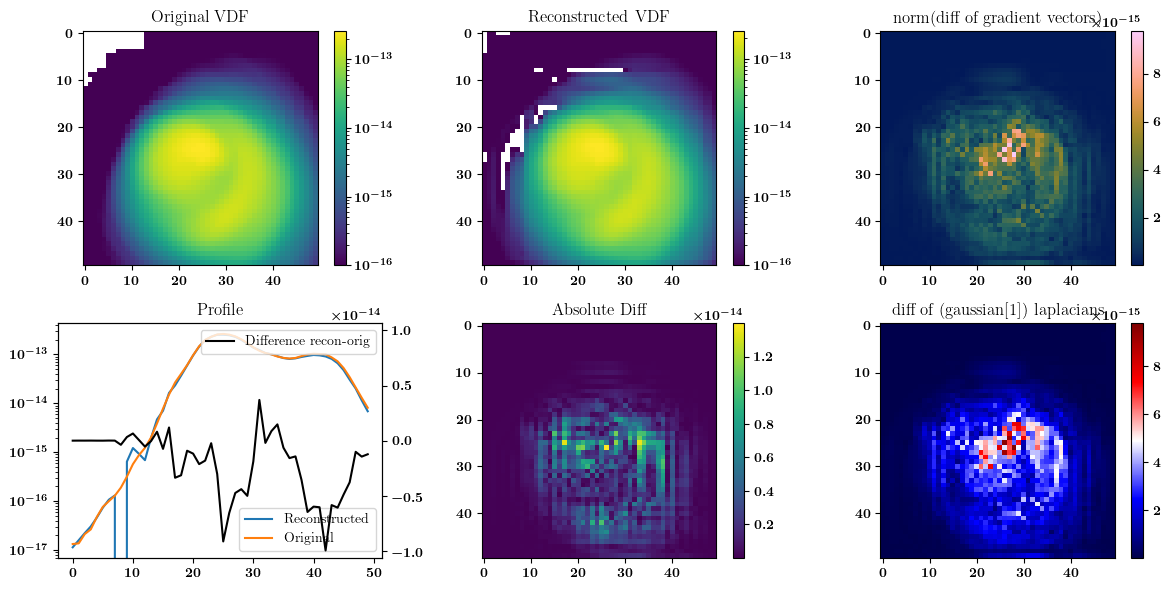

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (0.394, 0.114, '6.583e+00', '7.287e+00') %.
L1,L2 rNorms= (0.046, 0.044).


In [14]:
from scipy.fft import dctn, idctn

vdf_3d = vdf.copy()
orig_shape = vdf_3d.shape
vdf_3d[np.isnan(vdf_3d)] = 0

blocksize = 8
paddings = (np.ceil(np.array(vdf_3d.shape)/8)).astype(int)*8 - vdf_3d.shape
paddings = ((0,paddings[0]),(0,paddings[1]),(0,paddings[2]))
vdf_3d = np.pad(vdf_3d, paddings)

# dct_data = dctn(vdf_3d)
# print(dct_data.shape)
# vdf_rec = idctn(dct_data)
# print(vdf_rec.shape)

block_data = np.zeros_like(vdf_3d)
for i in range(0,vdf_3d.shape[0], blocksize):
    for j in range(0, vdf_3d.shape[1], blocksize):
        for k in range(0, vdf_3d.shape[2], blocksize):
            block_data[i:i+blocksize,j:j+blocksize, k:k+blocksize] = dctn(vdf_3d[i:i+blocksize,j:j+blocksize, k:k+blocksize])

keep_n = 4
zeroed = np.zeros_like(block_data)
for i in range(keep_n):
    for j in range(keep_n):
        for k in range(keep_n):
            zeroed[i::blocksize,j::blocksize,k::blocksize] = block_data[i::blocksize,j::blocksize,k::blocksize]

# fig, ax = plt.subplots()
# ax.pcolor(np.log(np.abs(zeroed[:,0,:])))


volume_compressed = np.prod(keep_n*np.ceil(np.array(vdf_3d.shape)/8))
volume_orig = np.prod(vdf_3d.shape)
compression = volume_orig/volume_compressed

vdf_rec = np.zeros_like(vdf_3d)
for i in range(0,vdf_3d.shape[0], blocksize):
    for j in range(0, vdf_3d.shape[1], blocksize):
        for k in range(0, vdf_3d.shape[2], blocksize):
            vdf_rec[i:i+blocksize,j:j+blocksize, k:k+blocksize] = idctn(zeroed[i:i+blocksize,j:j+blocksize, k:k+blocksize])

print("compression:", compression)
# vdf_rec = idctn(dct_data)
vdf_rec = vdf_rec[0:orig_shape[0],0:orig_shape[1],0:orig_shape[2]]

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)

### Principal Component Analysis (PCA)

Compression achieved using PCA = 83.33


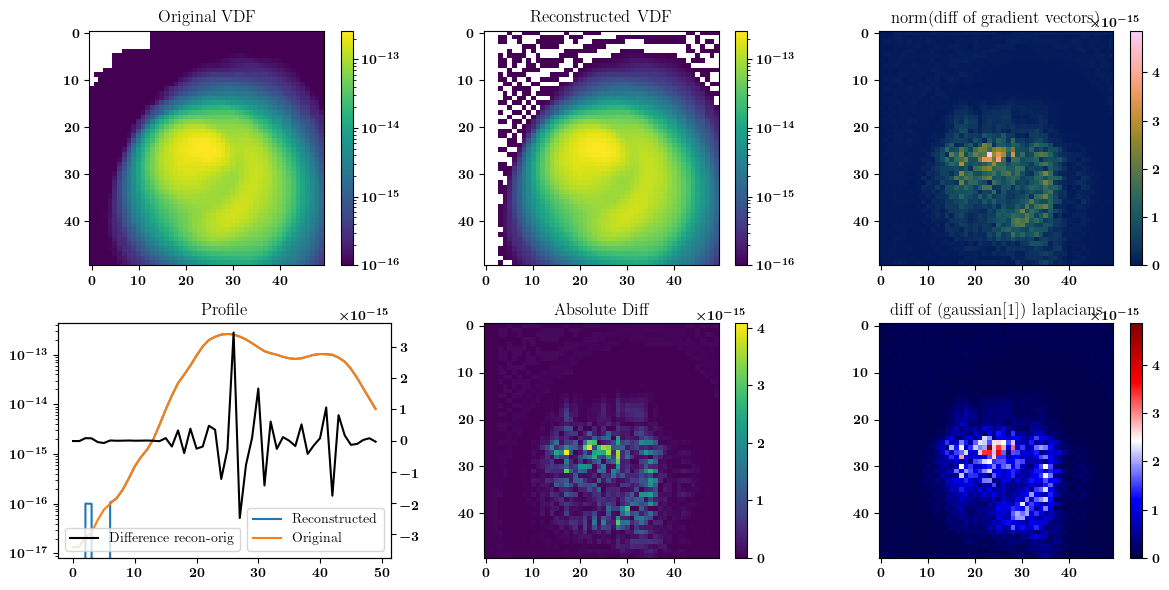

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (0.031, 0.002, '4.125e-01', '2.054e-01') %.
L1,L2 rNorms= (0.006, 0.007).


In [15]:
import numpy as np
from sklearn.decomposition import PCA
vdf_temp=vdf.copy()
vdf_temp[vdf_temp<1e-16]=1e-16
vdf_temp = np.log10(vdf_temp)
arr=vdf_temp.copy()
arr = arr.reshape(arr.shape[0], -1)

# perform pca
cov_matrix = np.cov(arr, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
pca = PCA(n_components=30)
compressed = pca.fit_transform(arr)
#reconstruct the data
recon = pca.inverse_transform(compressed)
nx,ny,nz=np.shape(vdf_temp)
recon=np.reshape(recon,(nx,ny,nz))
recon = 10 ** recon
recon[recon <= 1e-16] = 0
print(f"Compression achieved using PCA = {round(vdf_temp.size / compressed.size, 2)}")
project_tools.plot_vdfs(vdf, recon)
project_tools.print_comparison_stats(vdf,recon)

### Discrete Wavelet Transform (DWT)

Here we employ the PyWavelets package for prototyping compression via Discrete Wavelet Transforms [@lee_2019].

First, we test quantizing the coefficients as a sanity check.

42.333332 0.0 6.181394286686531e-15
-0.13590407 123.29804 27
-14.305042 10.792248 27
-6.5794706 10.859857 27
-1.700069 1.7653055 27
-13.229418 8.781471 27
-1.8120434 1.5420057 27
-1.755705 1.834994 27
-0.80956554 0.69174093 27
compression: 3.9782115297321834


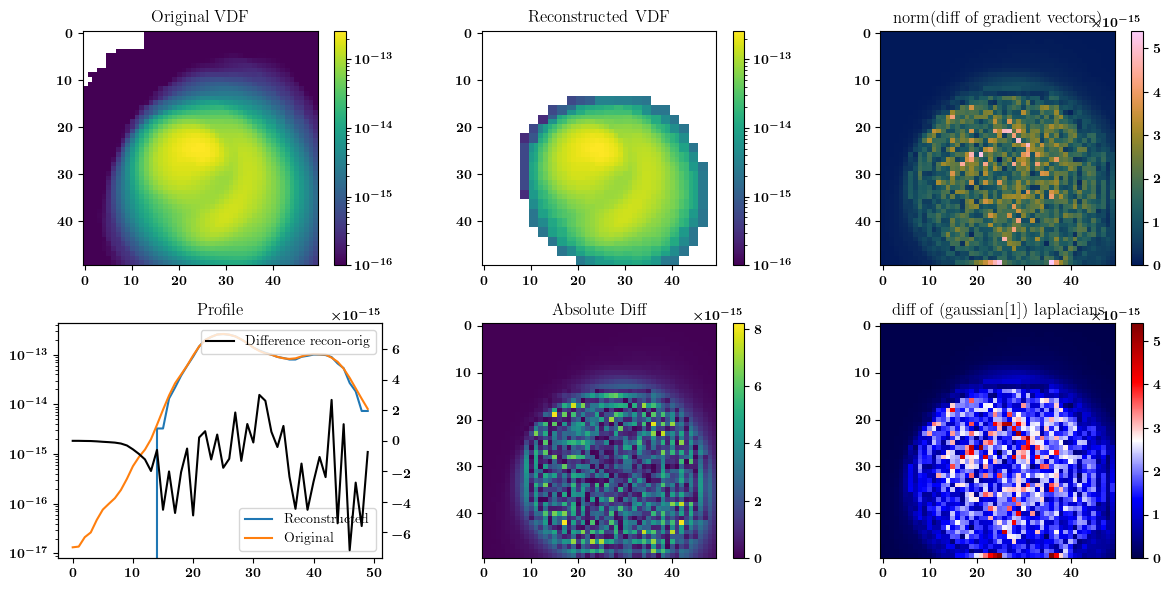

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (6.009, 0.834, '1.236e+01', '1.46e+01') %.
L1,L2 rNorms= (0.082, 0.058).


In [16]:
import pywt

# print(pywt.wavelist())

vdf_3d = vdf.copy()
orig_shape = vdf_3d.shape
vdf_3d[np.isnan(vdf_3d)] = 0

comp_type = np.int8
quant = np.iinfo(comp_type).max/3
# quant = np.finfo(comp_type).max/3
# quant_min = np.iinfo(comp_type).min/3

# norm = np.max([np.nanmax(vdf_3d)/quant_max, np.nanmin(vdf_3d)/quant_min])
# print(quant_max, quant_min, norm)

norm = np.nanmax(vdf_3d)/quant

vdf_3d /= norm
vdf_3d[vdf_3d<0]=0
print(np.nanmax(vdf_3d),np.nanmin(vdf_3d), norm)


coeffs3 = pywt.dwtn(vdf_3d,'bior1.3')

# print(coeffs3)
coeffs3_compress = coeffs3.copy()

for k, v in coeffs3.items():
    print(np.min(v),np.max(v), len(v))
    coeffs3_compress[k] = v.astype(comp_type)


vdf_rec = pywt.idwtn(coeffs3_compress,'bior1.3')*norm




volume_compressed = 0
for k,v in coeffs3_compress.items():
    volume_compressed += sys.getsizeof(v)
volume_orig = 0
for k,v in coeffs3.items():
    volume_orig += sys.getsizeof(v)
compression = volume_orig/volume_compressed

print("compression:", compression)

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)

Next, we try a naive thresholding operation on the coefficients for reconstruction. The results are encouraging, and a more elaborate thresholding scheme could help with capturing details at the fringes.

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
2.6167902e-13 0.0 1
Decomposing to

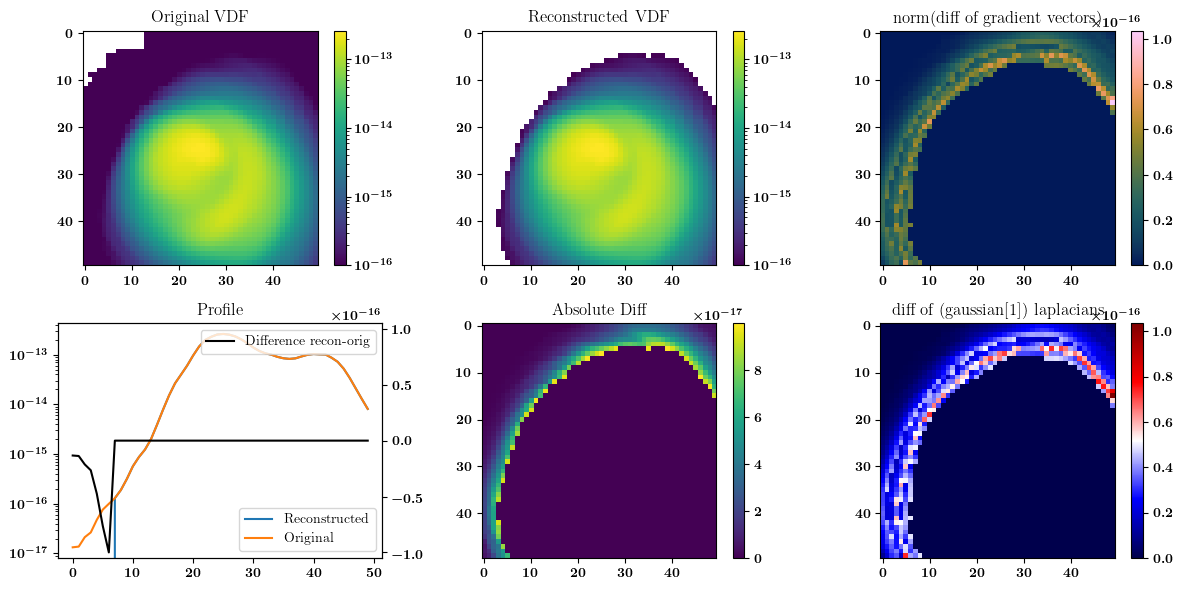

(3, 50, 50, 50)
(3, 50, 50, 50)
Velocity Moment relative differences (n,V,P_diag, P_frobenius)= (0.038, 0.005, '5.151e-02', '9.978e-02') %.
L1,L2 rNorms= (0.0, 0.001).


In [17]:
import pywt

print(pywt.wavelist(kind='discrete'))

vdf_3d = vdf.copy()
orig_shape = vdf_3d.shape
vdf_3d[np.isnan(vdf_3d)] = 0

comp_type = np.float32
# quant = np.iinfo(comp_type).max/3


norm = 1# np.nanmax(vdf_3d)/quant

vdf_3d /= norm
vdf_3d[vdf_3d<0]=0
print(np.nanmax(vdf_3d),np.nanmin(vdf_3d), norm)

wavelet = 'db4'#'bior1.3'

dwtn_mlevel = pywt.dwtn_max_level(vdf_3d.shape,wavelet)
level_delta = 2
print("Decomposing to ", dwtn_mlevel-level_delta, "levels out of ", dwtn_mlevel)
coeffs3 = pywt.wavedecn(vdf_3d,wavelet=wavelet, level = dwtn_mlevel-2)

# print(coeffs3)
coeffs3_comp = coeffs3.copy()
print(type(coeffs3_comp))

zeros = 0
nonzeros = 0
threshold = 1e-16
for i,a in enumerate(coeffs3_comp):
    print(type(a))
    zero_app = False
    # print(a.shape)
    if(type(a) == type(np.ndarray(1))):
        coeffs3_comp[i] = a
        mask = np.abs(a) < threshold
        zeros += np.sum(mask)
        nonzeros += np.sum(~mask)
        # nonzeros += np.prod(a.shape)
        coeffs3_comp[i][mask] = 0
    else:
        for k,v in a.items():
            mask = np.abs(v) < threshold
            coeffs3_comp[i][k] = v
            coeffs3_comp[i][k][mask] = 0
            zeros += np.sum(mask)
            nonzeros += np.sum(~mask)

print("number of zeros:", zeros, "nonzeros:", nonzeros)
vdf_rec = pywt.waverecn(coeffs3_comp,wavelet=wavelet)*norm

compression = (np.prod(vdf_3d.shape)/nonzeros)


# volume_compressed = 0
# for k,v in coeffs3_compress.items():
#     volume_compressed += sys.getsizeof(v)
# volume_orig = 0
# for k,v in coeffs3.items():
#     volume_orig += sys.getsizeof(v)
# compression = volume_orig/volume_compressed

print("compression:", compression)

project_tools.plot_vdfs(vdf,vdf_rec)
project_tools.print_comparison_stats(vdf,vdf_rec)

Lastly, stationary wavelet transforms might have desirable qualities. However, computing these is very slow with the current package, and this output is disabled for now.

In [18]:
if False:
    import pywt

    print(pywt.wavelist(kind='discrete'))

    vdf_3d = vdf.copy()
    orig_shape = vdf_3d.shape
    vdf_3d[np.isnan(vdf_3d)] = 0

    mlevel = 6
    paddings = (np.ceil(np.array(vdf_3d.shape)/2**mlevel)).astype(int)*2**mlevel - vdf_3d.shape
    paddings = ((0,paddings[0]),(0,paddings[1]),(0,paddings[2]))
    vdf_3d = np.pad(vdf_3d, paddings)

    comp_type = np.float32
    # quant = np.iinfo(comp_type).max/3


    norm = 1# np.nanmax(vdf_3d)/quant

    vdf_3d /= norm
    vdf_3d[vdf_3d<0]=0
    # print(np.nanmax(vdf_3d),np.nanmin(vdf_3d), norm)

    wavelet = 'db4'#'bior1.3'
    coeffs3 = pywt.swtn(vdf_3d, wavelet, mlevel)

    # print(coeffs3)
    coeffs3_comp = coeffs3.copy()

    zeros = 0
    nonzeros = 0
    threshold = 1e-15
    for i,a in enumerate(coeffs3_comp):
        # print(type(a))
        # print(a.shape)
        if(type(a) == type(np.ndarray(1))):
            coeffs3_comp[i] = a
            mask = np.abs(a) < threshold
            zeros += np.sum(mask)
            nonzeros += np.sum(~mask)
            coeffs3_comp[i][mask] = 0
        else:
            for k,v in a.items():
                mask = np.abs(v) < threshold
                coeffs3_comp[i][k] = v
                coeffs3_comp[i][k][mask] = 0
                mask = np.abs(v) < threshold
                zeros += np.sum(mask)
                nonzeros += np.sum(~mask)

    print("number of zeros:", zeros, "nonzeros:", nonzeros)
    vdf_rec = pywt.iswtn(coeffs3_comp, wavelet)*norm

    compression = ((zeros+nonzeros)/nonzeros)


    # volume_compressed = 0
    # for k,v in coeffs3_compress.items():
    #     volume_compressed += sys.getsizeof(v)
    # volume_orig = 0
    # for k,v in coeffs3.items():
    #     volume_orig += sys.getsizeof(v)
    # compression = volume_orig/volume_compressed

    print("compression:", compression)
    vdf_rec = vdf_rec[0:orig_shape[0],0:orig_shape[1],0:orig_shape[2]]

    project_tools.plot_vdfs(vdf,vdf_rec)
    project_tools.print_comparison_stats(vdf,vdf_rec)

### Vector Quantized-Variational AutoEncoder (VQ-VAE)

This approach involves a different learning framework of first training an encoder-decoder scheme from a large set of existing data for compression and reconstruction and then packaging this scheme as a compression tool that can be called per-VDF. This is an example trained on a single VDF cell, but our use-case has already large amounts of training data available. Setting up large-scale training and assessment is to be done.

In [19]:
from tqdm.notebook import tqdm
import torch
import torchvision
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

In [20]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv3d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv3d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv3d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=5,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv3d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=1,
        )

        self.tconv = nn.ConvTranspose3d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=5,
            stride=1,
            padding=1,
        )
        
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 1)#3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose3d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    #output_padding=(1,1,1),
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        h = self.tconv(h)
        h = nn.ReLU()(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 4, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 4, 1, 2, 3)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv3d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

use_tb = True # Use Tensorboard (optional)

# Initialize model
use_ema = True # Use exponential moving average
model_args = {
    "in_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
model = VQVAE(**model_args).to(device)

# Initialize dataset
batch_size = 1
workers = 1

input_norm = (input_array - input_array.min())/(input_array.max() - input_array.min()) # MinMax normalization
input_tensor = torch.tensor(input_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions, move to device
train_dataset = input_tensor
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

# Multiplier for commitment loss. See Equation (3) in "Neural Discrete Representation Learning"
beta = 0.25

# Initialize optimizer
train_params = [params for params in model.parameters()]
lr = 3e-4
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

# Train model
epochs = 30
eval_every = 1
best_train_loss = float("inf")
model.train()

Using device: cpu


VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu0): ReLU()
      (down1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu1): ReLU()
      (final_conv): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): ReLU()
          (1): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (2): ReLU()
          (3): Conv3d(32, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv3d(128, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage()
  )
  (decoder): Decoder(
    (conv): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
 

In [22]:
# Util for Tensorboard plotting in color
def prep_fig(img):
    fig, ax = plt.subplots()
    im = ax.imshow(img, interpolation='none')
    #plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.close()

    return fig

In [23]:
# Tensorboard setup
if use_tb:
    writer = SummaryWriter("runs/ASTERIX VQ-VAE_"+str(model_args["num_hiddens"])+"h_ema"+str(model_args["use_ema"])+"_"+str(model_args["embedding_dim"])+"ed_res"+str(model_args["num_residual_layers"]))

# Training
for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0
    for (batch_idx, train_tensors) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = train_tensors[0].unsqueeze(0).to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs) #/ train_data_variance
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_train += 1

        if ((batch_idx + 1) % eval_every) == 0:
            print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
            total_train_loss /= n_train
            if total_train_loss < best_train_loss:
                best_train_loss = total_train_loss

            print(f"total_train_loss: {total_train_loss}")
            writer.add_scalar("tr loss: ", total_train_loss, epoch)

            print(f"best_train_loss: {best_train_loss}")
            print(f"recon_error: {total_recon_error / n_train}\n")

            total_train_loss = 0
            total_recon_error = 0
            n_train = 0
    # Visualize reconstructed VDF at each epoch
    #plt.imshow(out["x_recon"].squeeze(0).squeeze(0).detach().numpy()[:,:,25])
    #plt.show()

    if use_tb:
        # write to tensorboard
        writer.add_figure('reconstructed VDF', prep_fig(out["x_recon"].squeeze(0).squeeze(0)[:,:,25].detach().numpy()), epoch)

if use_tb:
    writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 0
batch_idx: 1
total_train_loss: 0.6054796576499939
best_train_loss: 0.6054796576499939
recon_error: 0.4470842778682709

epoch: 1
batch_idx: 1
total_train_loss: 2.50374174118042
best_train_loss: 0.6054796576499939
recon_error: 2.498750925064087

epoch: 2
batch_idx: 1
total_train_loss: 0.11175696551799774
best_train_loss: 0.11175696551799774
recon_error: 0.10647808015346527

epoch: 3
batch_idx: 1
total_train_loss: 0.11049198359251022
best_train_loss: 0.11049198359251022
recon_error: 0.10418708622455597

epoch: 4
batch_idx: 1
total_train_loss: 0.11846396327018738
best_train_loss: 0.11049198359251022
recon_error: 0.11150848865509033

epoch: 5
batch_idx: 1
total_train_loss: 0.09667039662599564
best_train_loss: 0.09667039662599564
recon_error: 0.08914097398519516

epoch: 6
batch_idx: 1
total_train_loss: 0.10148145258426666
best_train_loss: 0.09667039662599564
recon_error: 0.09354858845472336

epoch: 7
batch_idx: 1
total_train_loss: 0.10035587102174759
best_train_loss: 0.0966703966259

In [24]:
# Save model checkpoint (optional)
#torch.save({
#    'epoch': epochs,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict()
#    }, "./VQ-VAE_checkpoints/ASTERIX VQ-VAE_"+str(model_args["num_hiddens"])+"h_ema"+str(model_args["use_ema"])+"_"+str(model_args["embedding_dim"])+"ed_res"+str(model_args["num_residual_layers"])+"_e"+str(epochs)+".pt")

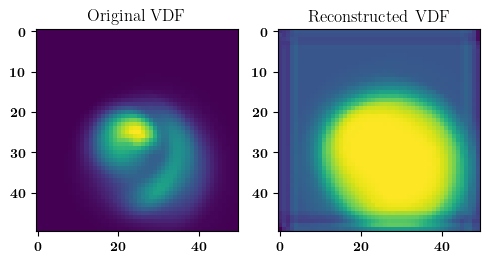

In [28]:
rec_vdf = out["x_recon"].squeeze(0).squeeze(0).detach().numpy()
rec_vdf_rescaled = (rec_vdf*(np.amax(input_array) - np.amin(input_array))) + np.amin(input_array)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(vdf[:,:,25])
axes[0].set_title("Original VDF")
axes[1].imshow(rec_vdf_rescaled[:,:,25])
axes[1].set_title("Reconstructed VDF")
fig.tight_layout()
plt.show()

## The random initialization of the cluster centroids in the embedding space, 
## can cause very different performance, e.g. when using the same input to train 
## (since in this case we train using a single VDF, we will expand during the next phase of the project).